# get COT data

In [85]:
import os, pandas as pd, numpy as np, json
from datetime import datetime, date, time
from dateutil.parser import parse
from zipfile import ZipFile

workPath = "/home/xetra/AlphaGoldmine/Data/"
cotPath = os.path.join(workPath,"COT")

futuresOptions = ["deahistfo_1995_2016.zip","deahistfo2017.zip","deahistfo2018.zip","deahistfo2019.zip","deahistfo2020.zip","deahistfo2021.zip",]
futures = ["deacot1986_2016.zip","deacot2017.zip","deacot2018.zip","deacot2019.zip","deacot2020.zip","deacot2021.zip",]

In [230]:
def dfFromZipCOT(path,zipNames,market=None):
    res = []
    for f in os.scandir(path):
        if f.name in zipNames:
            with ZipFile(f.path) as zf:
                for f in zf.namelist(): 
                    res.append(pd.read_csv(zf.open(f),parse_dates=["As of Date in Form YYYY-MM-DD"]))
    df = pd.concat(res)
    if market is not None: df = df[df["Market and Exchange Names"] == market]
    return df

In [274]:
cl = dfFromZipCOT(cotPath,futuresOptions,market="CRUDE OIL, LIGHT SWEET - NEW YORK MERCANTILE EXCHANGE")

/home/xetra/miniconda3/envs/ml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (3,121,122,123,124,126) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [275]:
cols = [
'As of Date in Form YYYY-MM-DD',
'Commercial Positions-Long (All)',
'Commercial Positions-Short (All)',
"Open Interest (All)",
'Concentration-Gross LT = 4 TDR-Long (All)',
'Concentration-Gross LT =4 TDR-Short (All)',
'Concentration-Gross LT =8 TDR-Long (All)',
'Concentration-Gross LT =8 TDR-Short (All)',
'Concentration-Net LT =4 TDR-Long (All)',
'Concentration-Net LT =4 TDR-Short (All)',
'Concentration-Net LT =8 TDR-Long (All)',
'Concentration-Net LT =8 TDR-Short (All)',
# 'Commercial Positions-Long (Old)',
# 'Commercial Positions-Short (Old)',
# 'Commercial Positions-Long (Other)',
# 'Commercial Positions-Short (Other)',
]

In [276]:
[c for c in cot.columns]

['Market and Exchange Names',
 'As of Date in Form YYMMDD',
 'As of Date in Form YYYY-MM-DD',
 'CFTC Contract Market Code',
 'CFTC Market Code in Initials',
 'CFTC Region Code',
 'CFTC Commodity Code',
 'Open Interest (All)',
 'Noncommercial Positions-Long (All)',
 'Noncommercial Positions-Short (All)',
 'Noncommercial Positions-Spreading (All)',
 'Commercial Positions-Long (All)',
 'Commercial Positions-Short (All)',
 ' Total Reportable Positions-Long (All)',
 'Total Reportable Positions-Short (All)',
 'Nonreportable Positions-Long (All)',
 'Nonreportable Positions-Short (All)',
 'Open Interest (Old)',
 'Noncommercial Positions-Long (Old)',
 'Noncommercial Positions-Short (Old)',
 'Noncommercial Positions-Spreading (Old)',
 'Commercial Positions-Long (Old)',
 'Commercial Positions-Short (Old)',
 'Total Reportable Positions-Long (Old)',
 'Total Reportable Positions-Short (Old)',
 'Nonreportable Positions-Long (Old)',
 'Nonreportable Positions-Short (Old)',
 'Open Interest (Other)',
 'N

In [277]:
cl = cl[cols].sort_values("As of Date in Form YYYY-MM-DD").reset_index(drop=True).rename(columns={"As of Date in Form YYYY-MM-DD":"date","Commercial Positions-Long (All)":"comLong",	"Commercial Positions-Short (All)":"comShort"})

In [278]:
net= cl["comLong"]-cl["comShort"]

In [279]:
r = net.rolling(window=12)
cl["cotIdx"]=((net-r.min()) / (r.max() - r.min()))

<AxesSubplot:title={'center':'COT Commercials Index'}>

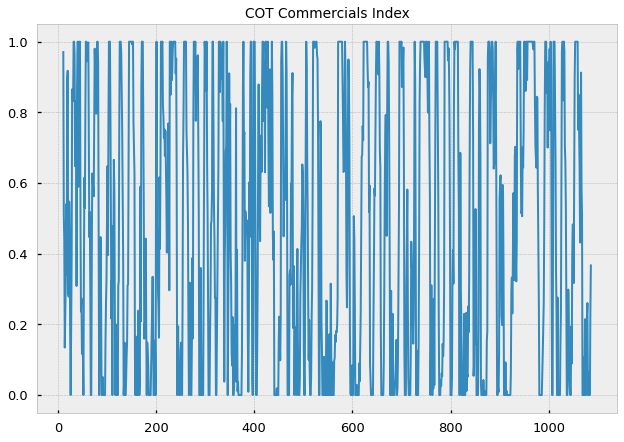

In [280]:
cl["cotIdx"].plot(title="COT Commercials Index")

# CFTC uses report date not release date in their reports

Report date is from Tuesday to Tuesday, and released every friday at 3:30 p.m. Eastern time.

So, we have to account for it, otherwise we do incorporated look ahead bias.
Since historical release dates are unknown, for me at least, couldn't find anything after hours of searching.

In [281]:
def getNextFriday(dt):
    return dt.date() + timedelta( (4-dt.weekday()) % 7 )

In [282]:
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
def applyGetReleaseDate(d):
    # get next friday
    fr = getNextFriday(d)
    # get business day (CFTC releases the next business day after friday, if friday is a holiday)
    return nyse.schedule(start_date=fr, end_date=fr+timedelta(days=10)).iloc[0,0].date()

In [283]:
cl["release"] = cl["date"].apply(applyGetReleaseDate)

<AxesSubplot:>

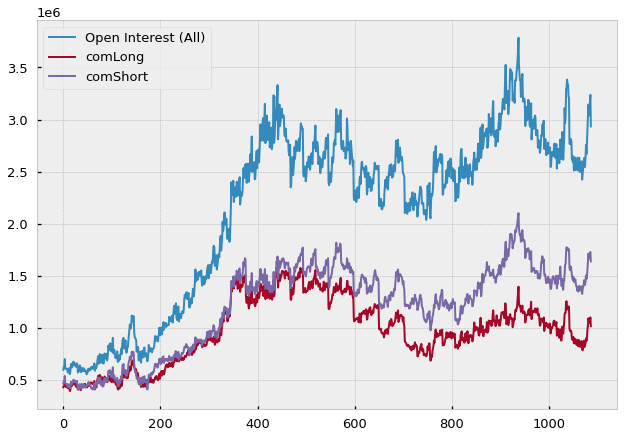

In [284]:
cl[["Open Interest (All)","comLong","comShort"]].plot()

# Concentration Ratios
The report shows the percents of open interest held by the largest four and eight reportable traders, without regard to whether they are classified as commercial or non-commercial. The concentration ratios are shown with trader positions computed on a gross long and gross short basis and on a net long or net short basis. The "Net Position" ratios are computed after offsetting each trader’s equal long and short positions. A reportable trader with relatively large, balanced long and short positions in a single market, therefore, may be among the four and eight largest traders in both the gross long and gross short categories, but will probably not be included among the four and eight largest traders on a net basis.

<AxesSubplot:>

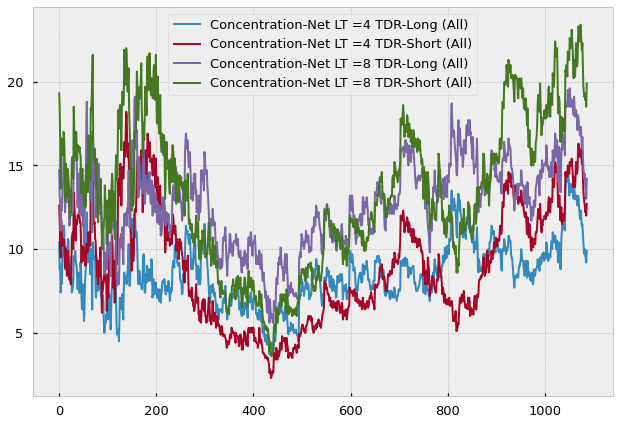

In [290]:
cl[[ 
    'Concentration-Net LT =4 TDR-Long (All)',
    'Concentration-Net LT =4 TDR-Short (All)',
    'Concentration-Net LT =8 TDR-Long (All)',
    'Concentration-Net LT =8 TDR-Short (All)',
]].plot()

<AxesSubplot:>

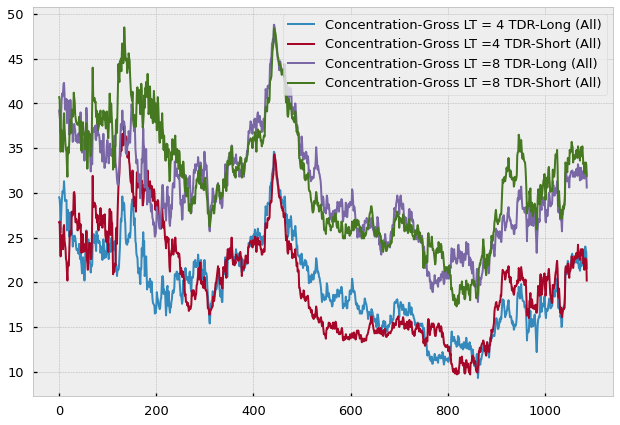

In [289]:
cl[[
    'Concentration-Gross LT = 4 TDR-Long (All)',
    'Concentration-Gross LT =4 TDR-Short (All)',
    'Concentration-Gross LT =8 TDR-Long (All)',
    'Concentration-Gross LT =8 TDR-Short (All)',
 ]].plot()